In [26]:
#@title Imports

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
import einops

In [27]:
#@title Hyperparameters

T = 1000 # Timesteps

In [28]:
#@title Device / CUDA

if torch.backends.mps.is_available():
    # Mac
    device = "mps"
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"

print(f'Using device: {device}')

Using device: cuda


In [29]:
def load_mnist(batch_size: int):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad((2, 2, 2, 2)),
    ])
    dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=data_transform)
    val_dataset = torchvision.datasets.MNIST(root="mnist/", train=False, download=True, transform=data_transform)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return dataset, data_transform, train_dataloader, val_dataloader

def load_cifar10(batch_size: int):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.CIFAR10(root="cifar10/", train=True, download=True, transform=data_transform)
    val_dataset = torchvision.datasets.CIFAR10(root="cifar10/", train=False, download=True, transform=data_transform)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return dataset, data_transform, train_dataloader, val_dataloader

def load_celebA(batch_size: int):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ])
    dataset = torchvision.datasets.CelebA(root="celeba/", split="train", download=True, transform=data_transform)
    val_dataset = torchvision.datasets.CelebA(root="celeba/", split="valid", download=True, transform=data_transform)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return dataset, data_transform, train_dataloader, val_dataloader

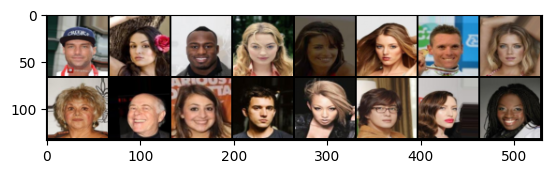

In [30]:
#@title Dataset
batch_size = 128

dataset, data_transform, train_dataloader, val_dataloader = load_celebA(batch_size)

# Display first 16 images
x, y = next(iter(train_dataloader))
x = x[:16]
grid = torchvision.utils.make_grid(x)
grid = rearrange(grid.cpu().numpy(), "c h w -> h w c")
plt.imshow(grid)

In [31]:
#@title Linear, cosine noise scheduler

class LinearNoiseScheduler(nn.Module):
    def __init__(self, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()
        self.timesteps = timesteps

        # Linearly spaced betas
        betas = torch.linspace(beta_start, beta_end, timesteps)

        # Precompute alphas and their cumulative products
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        # Register buffers (they move with the model to device, are saved with state_dict)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor):
        """
        Add noise to input `x` at timestep `t`.

        Args:
            x: Tensor of shape (B, C, H, W)
            t: Tensor of shape (B,) with integer timesteps (0 <= t < T)

        Returns:
            noisy_x: noised version of `x`
            noise: the noise added
        """
        B, C, H, W = x.shape

        # Get alpha_cumprod_t for each sample in the batch
        alpha_cumprod_t = self.alphas_cumprod[t].view(B, 1, 1, 1)  # Shape (B, 1, 1, 1)

        # Apply noise: x_t = sqrt(a_t) * x + sqrt(1 - a_t) * noise
        noisy_x = torch.sqrt(alpha_cumprod_t) * x + torch.sqrt(1 - alpha_cumprod_t) * noise

        return noisy_x

class CosineNoiseScheduler(nn.Module):
    """
    s = 0.008 is set by the authors of the paper (section 3.2)
    """
    def __init__(self, device: str, timesteps: int, s: int = 0.008):
        super().__init__()

        self.timesteps = timesteps
        self.s = s

        steps = self.timesteps + 1
        t = torch.linspace(0, self.timesteps, steps) / self.timesteps
        alpha_bar = torch.cos(((t + self.s) / (1 + self.s)) * math.pi * 0.5) ** 2 # Formula 2
        alpha_bar = alpha_bar / alpha_bar[0] # formula 1
        beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])

        self.alpha_bar = alpha_bar

        self.beta_t = torch.clamp(beta, max=0.999)
        self.alpha_t = 1. - self.beta_t
        self.alpha_cumprod = torch.cumprod(self.alpha_t, dim=0).to(device)
        self.alpha_hat_t = self.alpha_cumprod

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Adds "t" noise to "x0"

        x:      [B, C, H, W]
        noise:  [B, C, H, W]
        t:      [B, ]

        Returns:
            x_t: the noisy image at timestep t
            noise: the noise that was added
        """
        alpha_bar = self.alpha_cumprod[t.long()].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.9909697..3.9157772].


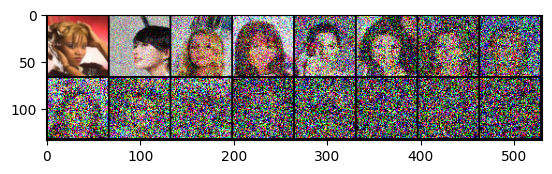

In [32]:
imgs, lbls = next(iter(train_dataloader))
imgs = imgs[:16].to(device)

t = torch.linspace(1, T-1, steps=16).long()
noise = torch.randn_like(imgs, device=device)
noisy_imgs = CosineNoiseScheduler(device, T).add_noise(imgs, noise, t)

grid = torchvision.utils.make_grid(noisy_imgs)
grid = rearrange(grid.cpu().numpy(), "c h w -> h w c")
plt.imshow(grid)

In [33]:
#@title Sinusodial embeddings

class SinusoidalEmbedding(torch.nn.Module):
    def __init__(self, embedding_dim: int, device: str):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.device = device

        assert self.embedding_dim % 2 == 0, "embedding_dim must be even"

    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, timesteps: Tensor) -> Tensor:
        # Create the frequency spectrum
        half_dim = self.embedding_dim // 2
        exponent = -math.log(10000.0) / (half_dim - 1)
        freq = torch.exp(torch.arange(half_dim, dtype=torch.float32) * exponent).to(self.device)
        # freq = freq.to(self.device)

        # Expand timesteps for broadcasting
        timesteps = timesteps.float().unsqueeze(1)  # (N, 1)
        args = timesteps * freq.unsqueeze(0)        # (N, half_dim)

        # Concatenate sin and cos
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)

        return embedding

class PositionalEmbedding(nn.Module):
    def __init__(self, T: int, output_dim: int, device: str) -> None:
        super().__init__()
        self.output_dim = output_dim
        self.device = device

        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, output_dim, 2) * (-math.log(10000.0) / output_dim))
        self.pe = torch.zeros(T, output_dim, device=device)
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)

    def forward(self, x: torch.Tensor):
        res = self.pe.to(device)[x].reshape(x.shape[0], self.output_dim)
        return res

# Model

Self-attention can be described like a Google query:

Query: what we are looking for (like Google search query)
Key: tag or identity or keywords of websites that Google indexs
Value: the full webpage of the website that Google indexed

Basically we type query, Google computes how similar the query is to each key (via dot product), Google uses similarity scores to weight the values (the actual content of each document), and the result is a mixture of different websites (weighted values), not just a single website.

**Pixel attention**: attention allows every pixel to attend to every other pixel, resulting in features



In [34]:
#@title Downsampling, DoubleConv, SelfAttention2d + AttnDownSampling

"""
From the paper:
"It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) [i.e. DoubleConvolution module] and a 2x2 max pooling operation with stride 2 for downsampling [i.e. DownSampling module]."
"""
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        pool = self.pool(down)
        return down, pool

"""
From the paper:
"Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU"
"""
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConvolution(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat((x1, x2), dim=1)
        return self.conv(x)

class SelfAttention2d(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key   = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv1d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling factor

    def forward(self, x: torch.Tensor):
        """
        Input: [B, C, H, W]
        Output: [B, C, H, W]
        """
        B, C, H, W = x.shape
        x_flat = rearrange(x, "b c h w -> b c (h w)") # [B, C, H*W]

        Q = self.query(x_flat)    # [B, C//8, H*W]
        K = self.key(x_flat)      # [B, C//8, H*W]
        V = self.value(x_flat)    # [B, C, H*W]

        attention = torch.bmm(Q.permute(0, 2, 1), K)  # [B, H*W, H*W]
        attention = F.softmax(attention / (C ** 0.5), dim=-1)

        out = torch.bmm(V, attention)  # [B, C, H*W]
        out = out.view(B, C, H, W)

        return self.gamma * out + x  # Residual connection

class AttnDownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels)
        self.attn = SelfAttention2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        attn_out = self.attn(down)
        pool = self.pool(attn_out)
        return attn_out, pool


In [35]:
class AttentionBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8):
        super().__init__()
        self.norm = nn.GroupNorm(32, dim)  # Normalize across channels
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_out = nn.Linear(dim, dim)
        self.num_heads = num_heads
        self.head_dim = dim // num_heads

    def forward(self, x):
        """
        x: [batch, channels, height, width]
        """
        b, c, h, w = x.shape
        x = self.norm(x)

        # Flatten spatial dimensions
        x = x.view(b, c, h * w).permute(0, 2, 1)  # [b, hw, c]

        # Linear projection for q, k, v
        qkv = self.qkv(x)  # [b, hw, 3c]
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape to [b, heads, hw, head_dim]
        q = q.view(b, h * w, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(b, h * w, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(b, h * w, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5), dim=-1)
        out = torch.matmul(attn, v)

        # Combine heads
        out = out.transpose(1, 2).reshape(b, h * w, c)
        out = self.attn_out(out)

        # Reshape back to [b, c, h, w]
        out = out.permute(0, 2, 1).view(b, c, h, w)
        return out + x.permute(0, 2, 1).view(b, c, h, w)  # Residual connection


In [36]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.ln = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.ln(x)

class PositionalEmbedding(nn.Module):
    def __init__(self, T: int, output_dim: int) -> None:
        super().__init__()
        self.output_dim = output_dim
        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, output_dim, 2) * (-math.log(10000.0) / output_dim))
        pe = torch.zeros(T, output_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        return self.pe[x].reshape(x.shape[0], self.output_dim)

class MultiheadAttention(nn.Module):
    def __init__(self, n_heads: int, emb_dim: int, input_dim: int) -> None:
        super().__init__()
        assert emb_dim % n_heads == 0
        head_dim = emb_dim // n_heads
        self.K_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.K_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.Q_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.Q_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.V_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.V_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.O_W = nn.Parameter(torch.rand(n_heads, head_dim, input_dim))
        self.O_b = nn.Parameter(torch.rand(input_dim))
        self.norm = nn.LayerNorm([input_dim])
        self.mlp = nn.Sequential(
            nn.LayerNorm([input_dim]),
            nn.Linear(input_dim, input_dim),
            nn.GELU(),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x, t):
        _, input_dim, h, w = x.shape
        x = einops.rearrange(x, "b c h w -> b (h w) c")
        res = x
        res = self.norm(x)
        k = einops.einsum(res, self.K_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        k = k + self.K_b
        q = einops.einsum(res, self.Q_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        q = q + self.Q_b
        qk = einops.einsum(q, k, "batch s1 n_h h_dim, batch s2 n_h h_dim -> batch n_h s1 s2")
        qk = qk / torch.sqrt(torch.tensor(input_dim, dtype=torch.float))
        qk = qk.softmax(-1)
        v = einops.einsum(res, self.V_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        v = v + self.V_b
        res = einops.einsum(qk, v, "batch n_h size size, batch size n_h h_dim -> batch size n_h h_dim")
        res = einops.einsum(res, self.O_W, "batch size n_h h_dim, n_h h_dim ch -> batch size ch")
        res = res + self.O_b
        res = res + x
        res = self.mlp(res) + res
        res = einops.rearrange(res, "b (h w) c -> b c h w", h=h, w=w)
        return res

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, is_residual=False, is_debug=False):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        )
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        )
        self.time_emb = MLP(input_dim=time_emb_dim, output_dim=out_channels)
        if in_channels != out_channels:
            self.conv_3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        else:
            self.conv_3 = nn.Identity()
        self.is_debug = is_debug
        self.is_residual = is_residual

    def forward(self, x, t):
        h = self.conv_1(x)
        if t is None:
            return self.conv_3(x) + self.conv_2(h)
        t = self.time_emb(t)
        batch_size, emb_dim = t.shape
        t = t.view(batch_size, emb_dim, 1, 1)
        if self.is_residual:
            return self.conv_3(x) + self.conv_2(h + t)
        else:
            return self.conv_2(h + t)


class DownBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x, t):
        return self.pool(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upscale = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)

    def forward(self, x, t):
        return self.upscale(x)

class SequenceWithTimeEmbedding(nn.Module):
    def __init__(self, blocks):
        super().__init__()
        self.models = nn.ModuleList(blocks)

    def forward(self, x, t):
        for model in self.models:
            x = model(x, t)
        return x

class UNet(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            T,
            steps=(1, 2, 4),
            hid_size = 128,
            attn_step_indexes = [1],
            has_residuals=True,
            num_resolution_blocks=2,
            is_debug = False
        ):
        super().__init__()

        time_emb_dim = hid_size * 4
        self.time_embedding = nn.Sequential(
            PositionalEmbedding(T=T, output_dim=hid_size),
            nn.Linear(hid_size, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.first_conv = nn.Conv2d(in_channels, steps[0] * hid_size, 3, padding=1)
        self.down_blocks = nn.ModuleList()
        prev_hid_size = steps[0] * hid_size
        for (index, step) in enumerate(steps):
            res_blocks = []
            for block in range(num_resolution_blocks):
                res_blocks.append(
                    ResnetBlock(
                        in_channels=prev_hid_size if block == 0 else step * hid_size,
                        out_channels=step * hid_size,
                        time_emb_dim=time_emb_dim,
                        is_residual=has_residuals
                    )
                )
                if step in attn_step_indexes:
                    res_blocks.append(
                        MultiheadAttention(
                            n_heads=4,
                            emb_dim=step * hid_size,
                            input_dim=step * hid_size
                        )
                    )
            self.down_blocks.append(
                SequenceWithTimeEmbedding(res_blocks)
            )
            if index != len(steps) - 1:
                self.down_blocks.append(DownBlock())
            prev_hid_size = step * hid_size
        if len(attn_step_indexes) > 0:
            self.backbone = SequenceWithTimeEmbedding([
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
                MultiheadAttention(n_heads=4, emb_dim=steps[-1] * hid_size, input_dim=steps[-1] * hid_size),
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
            ])
        else:
            self.backbone = SequenceWithTimeEmbedding([
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
            ])

        self.up_blocks = nn.ModuleList()
        reverse_steps = list(reversed(steps))
        for (index, step) in enumerate(reverse_steps):
            res_blocks = []
            for block in range(num_resolution_blocks):
                next_hid_size = reverse_steps[index + 1] * hid_size if index != len(steps) - 1 else step * hid_size
                res_blocks.append(
                    ResnetBlock(
                        in_channels=prev_hid_size * 2 if block == 0 else next_hid_size,
                        out_channels=next_hid_size,
                        time_emb_dim=time_emb_dim,
                        is_residual=has_residuals
                    )
                )
                if len(reverse_steps) - index - 1 in attn_step_indexes:
                    res_blocks.append(
                        MultiheadAttention(
                            n_heads=4,
                            emb_dim=next_hid_size,
                            input_dim=next_hid_size
                        )
                    )
            self.up_blocks.append(
                SequenceWithTimeEmbedding(res_blocks)
            )
            if index != len(steps) - 1:
                self.up_blocks.append(UpBlock(next_hid_size, next_hid_size))
            prev_hid_size = next_hid_size

        self.is_debug = is_debug
        self.out = nn.Sequential(*[
            nn.GroupNorm(8, steps[0] * hid_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=steps[0] * hid_size, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        ])

    def forward(self, x, t):
        time_emb = self.time_embedding(t)

        x = self.first_conv(x)
        hx = []
        for down_block in self.down_blocks:
            x = down_block(x, time_emb)
            if not isinstance(down_block, DownBlock):
                hx.append(x)
        x = self.backbone(x, time_emb)

        ind = len(hx) - 1
        for up_block in self.up_blocks:
            if not isinstance(up_block, UpBlock):
                x = up_block(torch.cat([x, hx[ind]], 1), time_emb)
                ind -= 1
            else:
                x = up_block(x, time_emb)
        x = self.out(x)

        return x

# Model formulas

## Sampling

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \hat{\epsilon} \right) + \sqrt{\beta_t} \cdot z$

where:

* $x_t$ current noisy image
* $\hat{\epsilon}$ predicted noise
* $\alpha_t$ noise schedule at timestep $t$
* $\bar{\alpha}_t$ cumulative product of alphas
* $\beta_t$ noise variance at timestep $t$
* $z$ pure noise sampled from $\mathcal{N} (0, I)$


In [37]:
class Model(nn.Module):
    def __init__(self, T: int, in_channels: int, out_channels: int, device: str, noise_sched: Any):
        super().__init__()

        self.T = T
        self.input_channels = in_channels
        self.device = device
        self.noise_sched = noise_sched

        # Loss function
        self.loss_function = nn.MSELoss()
        # self.loss_function = F.l1_loss

        # U-Net
        self.unet = UNet(
            in_channels = in_channels,
            out_channels = out_channels,
            T = T,
            steps = (1, 2),
            hid_size = 128,
            attn_step_indexes = [1, 2],
            has_residuals = True,
            num_resolution_blocks = 2,
            is_debug = False
        )

    def calculate_loss(self, imgs: torch.Tensor):
        t = torch.randint(low=1, high=T, size=(imgs.shape[0],), device=device)

        noise = torch.randn_like(imgs, device=device)

        # get noise image as: sqrt(alpha_t_bar) * x0 + noise * sqrt(1 - alpha_t_bar)
        b, c, h, w = imgs.shape
        noise_imgs = self.noise_sched.add_noise(imgs, noise, t)

        # get predicted noise from our model
        pred_noise = self.unet(noise_imgs, t)

        # calculate of Loss simple ||noise - pred_noise||^2, which is MSELoss
        loss = self.loss_function(pred_noise, noise)
        return loss

    @torch.no_grad
    def sample(self, sample_size: Tuple[int, int, int, int]):
        """
        sample_size: batch, channels, height, width
        """
        self.eval()

        b, c, h, w = sample_size

        # get Gaussian distribution noise (step T)
        x_t = torch.randn(sample_size, device=self.device)

        # Calculate x_(t-1) every iteration: T, T-1, ..., 2, 1, 0 until we get denoised image
        for t_step in range(self.T - 1, 0, -1):
            # The same t step is applied to all images in the batch
            t_tensor = torch.tensor([t_step]).repeat(b, 1).squeeze(1)

            # Noise prediction from unet
            pred_noise = self.unet(x_t, t_tensor)

            # When t = 0, noise should be 0 just like the formula in the DDPM paper
            if t_step > 0:
                z = torch.randn_like(x_t, device=self.device)
            else:
                z = 0

            # Formula from How to get sample
            # x_(t-1) = 1 / sqrt(alpha_t) * (x_t - pred_noise * (1 - alpha_t) / sqrt(1 - alpha_t_bar)) + beta_t * epsilon

            alpha_t_schedule = self.noise_sched.alpha_t
            alpha_hat_t = self.noise_sched.alpha_hat_t
            sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1 - alpha_hat_t)
            beta_schedule = self.noise_sched.beta_t

            x_t = 1 / torch.sqrt(alpha_t_schedule[t_step]) * \
                (x_t - pred_noise * (1 - alpha_t_schedule[t_step]) / sqrt_minus_bar_alpha_t_schedule[t_step]) + \
                torch.sqrt(beta_schedule[t_step]) * z

        return x_t


In [38]:
model = Model(
    T,
    in_channels=3,
    out_channels=3,
    device=device,
    noise_sched = CosineNoiseScheduler(device, T)
)
model.to(device)

;

''

In [39]:
#@title Train loop

num_of_params = sum([p.numel() for p in model.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 9,832,707


In [40]:
@torch.no_grad
def plot_pred(epoch: int, noise_sched: Any, batch_index: Optional[int] = None):
    # Fetch some data
    x, y = next(iter(train_dataloader))
    batch_size = 8
    x = x[:batch_size] # Only using the first 8 for easy plotting

    # Corrupt with a range of amounts
    t = torch.linspace(0, T-1, batch_size).long().to(device)
    noise = torch.randn_like(x).to(device)
    x = x.to(device)
    noisy_x = noise_sched.add_noise(x, noise, t).to(device)

    # Get the model predictions
    with torch.no_grad():
        preds = model.unet(noisy_x, t).detach().cpu()

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 7))
    axs[0].set_title('Input data')
    axs[0].imshow(torchvision.utils.make_grid(x.cpu())[0].clip(0, 1), cmap='gray')
    axs[1].set_title('Corrupted data')
    axs[1].imshow(torchvision.utils.make_grid(noisy_x.cpu())[0].clip(0, 1), cmap='gray')

    txt = f'Network Predictions, epoch {epoch}'
    if batch_index:
        txt += f", batch {batch_index}"

    axs[2].set_title(txt)
    axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='gray')
    plt.show()

@torch.no_grad()
def plot_samples(epoch: Optional[int], batch_index: Optional[int]):
    n_samples = 64

    imgs, lbls = next(iter(train_dataloader))
    c, h, w = imgs[0].shape

    x = model.sample((n_samples, c, h, w)).detach().cpu()

    grid = torchvision.utils.make_grid(x, nrow=8)
    grid = rearrange(grid, 'c h w -> h w c')

    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap="gray")

    txt = "Samples"

    if epoch is not None:
        txt += f": epoch {epoch}"

    if batch_index is not None:
        txt += ", batch {batch_index}"

    plt.title(txt)
    plt.axis("off")
    plt.show()

In [41]:
def train(
        optimizer: torch.optim.Optimizer,
        device: str,
        num_epochs: int,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader
    ):

    batch_train_losses = []
    batch_val_losses = []
    epoch_train_losses = []
    epoch_val_losses = []

    # The training loop
    for epoch in range(num_epochs):
        model.train(True)

        clear_output(wait=True) # Clean jupyter cell
        plot_samples(epoch, None)

        train_loss = 0

        pbar = tqdm(train_dataloader)

        for batch_index, (imgs, labels) in enumerate(pbar):
            optimizer.zero_grad()

            x = imgs.to(device)

            loss = model.calculate_loss(x)

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            train_loss += loss.item()

            pbar.set_postfix(epoch=epoch, loss=loss.item())

        # End of epoch

        epoch_train_losses.append(train_loss / len(train_dataloader))

    clear_output(wait=True) # Clean jupyter cell
    plot_samples(epoch, None)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_dataloader:
                imgs = imgs.to(device)

                loss = model.calculate_loss(imgs)

                val_loss += loss.item()

                batch_val_losses.append(loss.item())
        epoch_val_losses.append(val_loss / len(val_dataloader))

    return epoch_train_losses, batch_train_losses, epoch_val_losses, batch_val_losses

# Train

In [42]:
etl, btl, evl, bvl = train(
    optimizer=torch.optim.Adam(model.parameters(), lr=2e-3),
    device=device,
    num_epochs=40,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 16.68 GiB is allocated by PyTorch, and 13.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

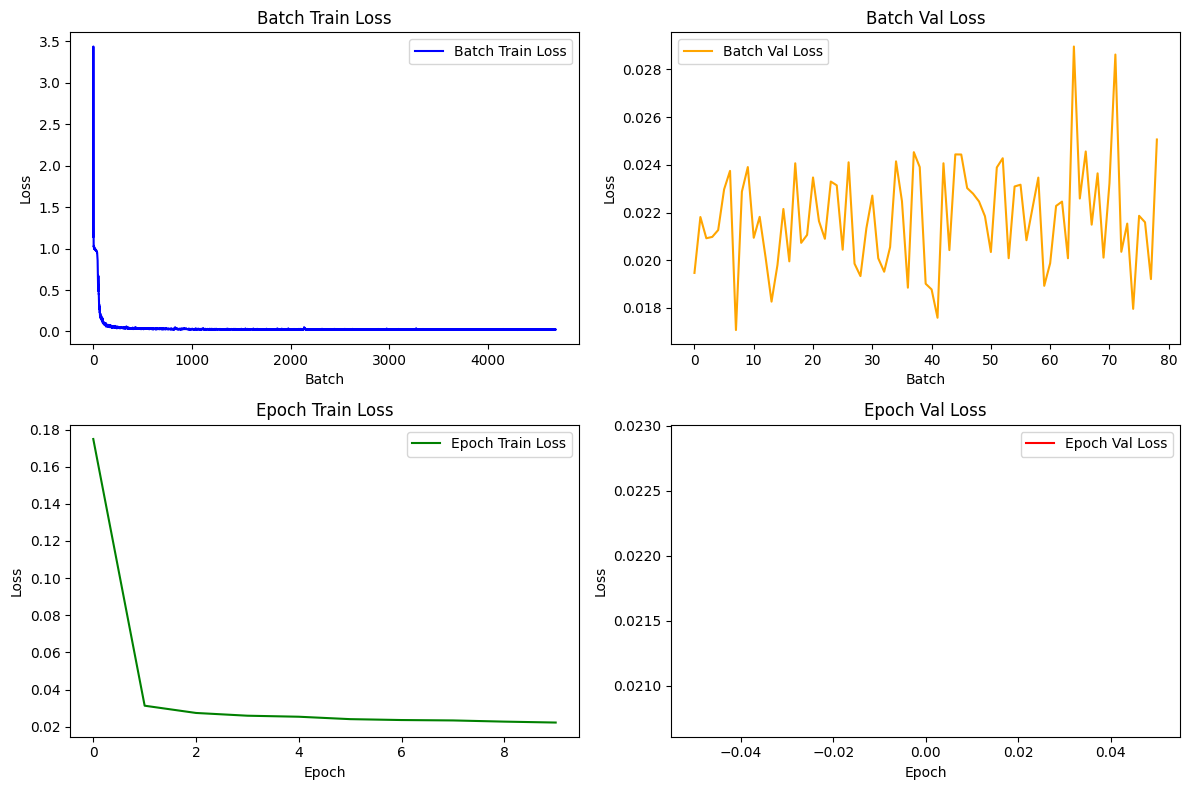

In [ ]:
def plot_all_losses(
    batch_train_losses, batch_val_losses, epoch_train_losses, epoch_val_losses
):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()  # flatten from 2D array to 1D list for easy indexing

    axes[0].plot(batch_train_losses, label='Batch Train Loss', color='blue')
    axes[0].set_title("Batch Train Loss")
    axes[0].set_xlabel("Batch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(batch_val_losses, label='Batch Val Loss', color='orange')
    axes[1].set_title("Batch Val Loss")
    axes[1].set_xlabel("Batch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    axes[2].plot(epoch_train_losses, label='Epoch Train Loss', color='green')
    axes[2].set_title("Epoch Train Loss")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()

    axes[3].plot(epoch_val_losses, label='Epoch Val Loss', color='red')
    axes[3].set_title("Epoch Val Loss")
    axes[3].set_xlabel("Epoch")
    axes[3].set_ylabel("Loss")
    axes[3].legend()

    plt.tight_layout()
    plt.show()

plot_all_losses(btl, bvl, etl, evl)

# Sampling

In [ ]:
# #@title Save the model

# path = "trained_model.pt"
# torch.save(model, path)

In [ ]:
# #@title Load model

# path = "trained_model.pt"
# model = torch.load(path, weights_only=False)
# model.to(device)
# model.eval()
# print("OK")

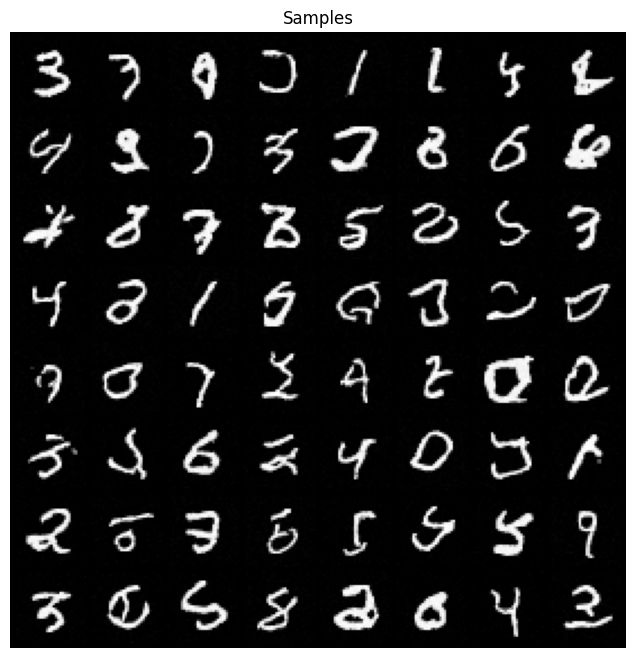

In [ ]:
#@title Sampling

plot_samples(None, None)